In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import os.path as op

from bauer.utils.math import softplus_np
import matplotlib.pyplot as plt

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
bids_folder  = '/data/ds-tmsrisk'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

# Model 1

In [3]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

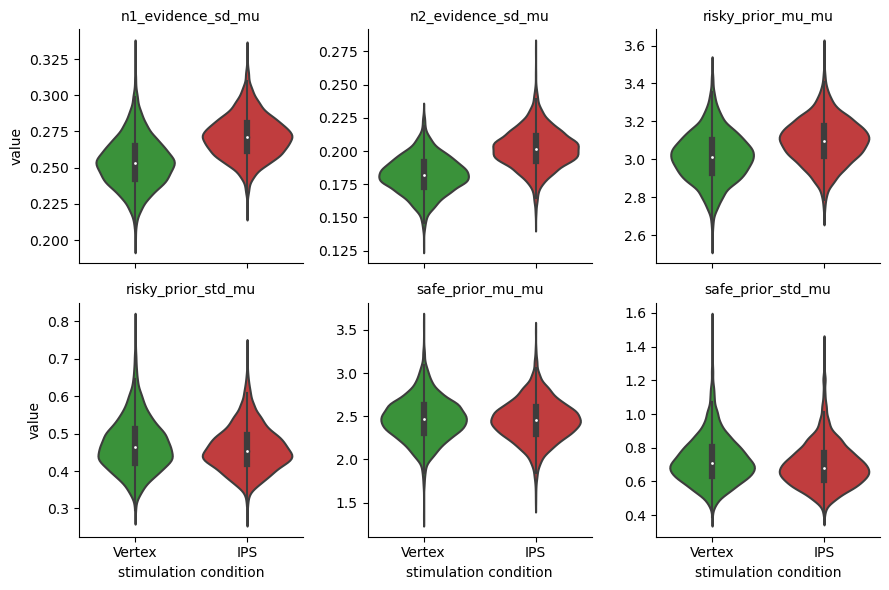

In [6]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

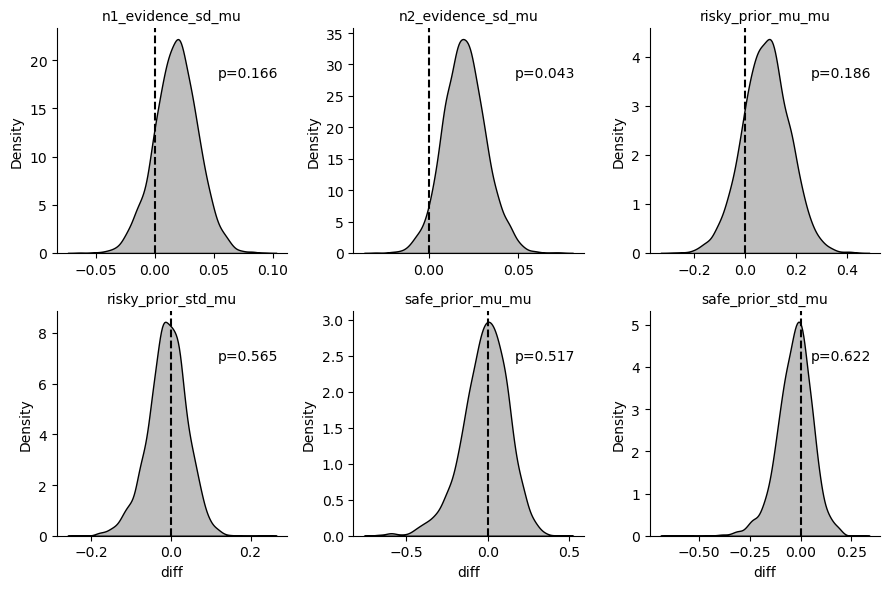

In [7]:
tmp = pars.unstack('stimulation condition')['value']
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

# Model 1a

In [20]:
idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1a_trace.netcdf'))

In [21]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    
    if key in  ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu']:
        vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
    else:
        vertex_values = ips_values

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

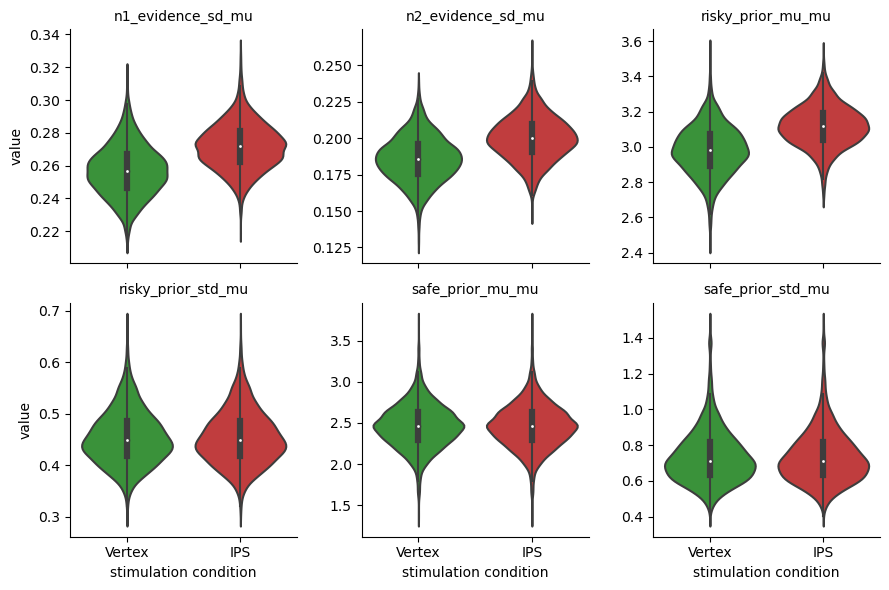

In [22]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

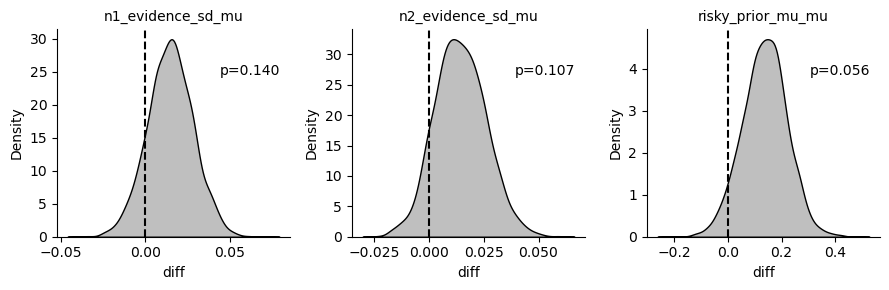

In [25]:
tmp = pars.unstack('stimulation condition')['value'].drop(['safe_prior_std_mu', 'safe_prior_mu_mu', 'risky_prior_std_mu'], level='parameter')
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

# Model 1: subjectwise

In [27]:
bids_folder  = '/data/ds-tmsrisk'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

In [28]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

In [29]:
pars

value
stimulation condition chain draw subject parameter                
IPS                   0     0    1       n1_evidence_sd   0.205740
                                         n2_evidence_sd   0.194213
                                         risky_prior_mu   2.697249
                                         risky_prior_std  0.450068
                                         safe_prior_mu    2.913162
...                                                            ...
Vertex                3     999  74      n2_evidence_sd   0.171886
                                         risky_prior_mu   2.646843
                                         risky_prior_std  0.544690
                                         safe_prior_mu    4.533704
                                         safe_prior_std   0.605658

[1680000 rows x 1 columns]